In [1]:
from src.utils.gpu import print_num_gpus_available

print_num_gpus_available()

Numero de GPU disponibles:  1
Dispositivo de GPU por defecto: /device:GPU:0


In [2]:
from src.settings import config
from src.utils.utils import *
import matplotlib.pyplot as plt
from src.parameters.image_parameters import *
from src.parameters.model_parameters import *
import tensorflow as tf

# --------------Configuraciones Iniciales---------------------------------
config.DEBUG_MODE = False
config.DEBUG_MODE_MODELS = False
config.SAVE_MODEL_COMPLETE_MLFlow = False
config.LOG_MODEL_MLFlow = False
config.LOG_JSON_TXT_MODEL_MLFlow = True

# -------------Configuraciones del Pipeline------------------------
mode_classification = "ClassBMN"
# mode_classification = "BinaryNM"
# mode_classification = "ClassBMN" #BinaryNM
dataset = "MINI-DDSM"
# dataset = "MIAS"
name_red = "MobilNet2"
path_to_classification = "data/dataset_raw/" + dataset + "/" + mode_classification

width_shape = 224
height_shape = 224
epochs = 11
batch_size = 5
# class_mode -> 'categorical' 'binary'
class_mode = definite_class_mode(mode_classification)
#always -> 'grayscale' remove -> 'rgb'
color_mode = definite_mode_read()

# --------------Parametros del Modelo para compilar-------------------------
from tensorflow.keras.optimizers import Adam, SGD, Adadelta

#'binary_crossentropy' 'categorical_crossentropy'
loss = definition_loss(mode_classification)
learning_rate = 1e-3
optimizer = Adam(learning_rate=learning_rate)
# optimizer = Adadelta(learning_rate=learning_rate)

list_metric = get_list_metrics(mode_classification)  # BinaryAccuracy(), CategoricalAccuracy(),
validation_split = 0.2

E:\anaconda3\envs\env_breast_cancer\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
amount_images_to_classification(path_to_classification, mode_classification)
print("Carpeta de clasificación:", mode_classification)
print("epochs:", epochs)
print("batch size:", batch_size)
print("class mode:", class_mode)
print("color mode:", color_mode)
print("Loss:", loss)
print("Taza de aprendisaje:", learning_rate)
print("Metricas:", list(map(name_metric, list_metric)))
print("Porcentaje para validación:", validation_split)

Benigno: 2684
Maligno: 2716
Normal: 2408
Carpeta de clasificación: ClassBMN
epochs: 11
batch size: 5
class mode: categorical
color mode: grayscale
Loss: categorical_crossentropy
Taza de aprendisaje: 0.001
Metricas: ['precision', 'recall', 'categorical_accuracy']
Porcentaje para validación: 0.2


Found 6248 images belonging to 3 classes.
Found 1560 images belonging to 3 classes.
División de datos de entrenamiento y prueba completado


(224, 224, 1)


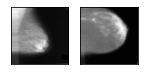

In [4]:
datagen = generate_ImageDataGenerator(color_mode, validation_split)
path_data = 'data/dataset_raw/' + dataset + '/' + mode_classification + '/'
data_gen_train = datagen.flow_from_directory(path_data,
                                             batch_size=batch_size, shuffle=True,
                                             target_size=(width_shape, height_shape),
                                             class_mode=class_mode,  #save_to_dir='',
                                             subset='training',
                                             color_mode=color_mode)
data_gen_test = datagen.flow_from_directory(path_data,
                                            batch_size=batch_size, target_size=(width_shape, height_shape),
                                            shuffle=True,
                                            class_mode=class_mode,
                                            subset='validation',
                                            color_mode=color_mode)
print("División de datos de entrenamiento y prueba completado")
#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_train:
    for i in range(2):
        # print(imagen[i].shape)
        # print(imagen[i][4].shape)
        # print(imagen[i][1].shape)
        plt.subplot(2, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        print()
        plt.imshow(imagen[i], cmap='gray')
        # plt.imshow(imagen[i])
    print(imagen[i].shape)
    break
plt.show()

In [5]:
from src.utils.utils import Save_model_summary_txt_architecture_json
from src.models.Models import create_model, transfer_learning

model = create_model(name_model=name_red, mode_classification=mode_classification)
if config.LOG_JSON_TXT_MODEL_MLFlow:
    Save_model_summary_txt_architecture_json(model)

Summary en txt creado
Arquitectura en json creado


E:\anaconda3\envs\env_breast_cancer\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [6]:
model.compile(optimizer=optimizer, loss=loss, metrics=list_metric)

In [7]:
# !fit_generator esta obsoleto
history = model.fit(
    data_gen_train, epochs=epochs, batch_size=batch_size,
    validation_data=data_gen_test
)

if config.LOG_MODEL_MLFlow:
    tf.keras.models.save_model(model, "temp/model/")

Epoch 1/11
1250/1250 [==============================] - 151s 105ms/step - loss: 1.0429 - precision: 0.4828 - recall: 0.1256 - categorical_accuracy: 0.4600 - val_loss: 1.1143 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_categorical_accuracy: 0.3083

In [8]:
import mlflow
from mlflow.entities import Metric
from mlflow.tracking import MlflowClient

# mlflow_client = MlflowClient()
# EXPERIMENT_NAME = "mini-ddsm"
# EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
# EXPERIMENT_ID = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(experiment_id=1, run_name=name_red) as active_run:
    # with mlflow.start_run(run_name=name_red) as active_run:
    mlflow_client = MlflowClient()
    # experiment_id = mlflow_client.create_experiment("Mamografías CNNs experimentos")
    # experiment_id = "0"
    # run = mlflow_client.create_run(experiment_id)
    all_metrics = []
    f1, val_f1 = get_F1_scores(history)
    for metric_name in history.history:
        for i in history.epoch:
            metric = Metric(
                key=metric_name,
                value=history.history[metric_name][i],
                timestamp=0,
                step=i,
            )
            all_metrics.append(metric)
    all_metrics = all_metrics + f1 + val_f1

    mlflow_client.log_batch(run_id=active_run.info.run_id, metrics=all_metrics)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="batch size", value=batch_size)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="learning rate", value=learning_rate)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="epochs", value=epochs)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="optimizer", value=optimizer.__class__.__name__)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Loss", value=loss)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="DB", value=dataset)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Transfer Learning", value=transfer_learning)
    mlflow_client.log_param(run_id=active_run.info.run_id, key="Folder para clasificar", value=mode_classification)

    if config.LOG_JSON_TXT_MODEL_MLFlow:
        mlflow.log_artifact("temp/summary_model.txt", artifact_path="arquitectura")
        mlflow.log_artifact("temp/architecture.json", artifact_path="arquitectura")
    if config.LOG_MODEL_MLFlow:
        mlflow_client.log_artifacts(run_id=active_run.info.run_id, local_dir="temp/model/")

    mlflow_client.log_batch(run_id=active_run.info.run_id, metrics=all_metrics)
    print("Todas las metricas guardadas")
# ?Guardar las metricas por cada epoca
# tags = {'Transfer Learning:': transfer_learning}
# mlflow_client.set_experiment_tag(0, "name DB", dataset)


Todas las metricas guardadas


In [9]:
mlflow.end_run()
print("Se detuvo MLFlow")

Se detuvo MLFlow


In [10]:
# acc = history.history['categorical_accuracy']
# val_acc = history.history['val_categorical_accuracy']
#
# loss = history.history['loss']
# val_loss = history.history['val_loss']
#
# rango_epocas = range(epochs)
#
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(rango_epocas, acc, label='accuracy Entrenamiento')
# plt.plot(rango_epocas, val_acc, label='accuracy Pruebas')
# plt.legend(loc='lower right')
# plt.title('Precisión de entrenamiento y pruebas')
#
# plt.subplot(1, 2, 2)
# plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
# plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
# plt.legend(loc='upper right')
# plt.title('Pérdida de entrenamiento y pruebas')
# plt.show()

In [11]:
# import pandas as pd
#
# column_values = ['accuracy de train',
#                  'accuracy de pruebas',
#                  'perdida de train',
#                  'perdida de pruebas']
# array = list(zip(acc, val_acc, loss, val_loss))
# df = pd.DataFrame(data=array, columns=column_values)
# df
# df.describe()

Puntos de rescatar con erick:
- Para erick usar F1 como predominante, igual preguntar al profe Ochoa
- Se puede poner las metricas en 2 tablas tanto para el conjunto de preubas y entrenamiento
- En el resumen del conjunto de datos poner la cantidad de datos y resolución y etiquetas si es posible

